# BBCA Stock Price Prediction Model

## Project Background
Stock price prediction is a significant area of interest in financial markets. It involves using historical price data and machine learning techniques to forecast future stock prices. BBCA is a popular stock price of Bank Central Asia owned by many investors. By creating a prediction model, it'll hopefully minimizes risk for these investors.

## Objectives
- Build machine learning models to forecast BBCA future prices.
- Evaluate each models and choose the best model.

## Dataset
In this project, we use the monthly historical stock prices of Bank Central Asia (BBCA) from January 1, 2015 to January 1, 2025, with the column descriptions provided below.

- Price: The closing price of the stock
- Open: The opening price of the stock
- High: The highest price of the stock
- Low: The lowest price of the stock
- Volume: The total number of shares traded in a single day

In [156]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

### Import Data

In [157]:
# load dataset
stock_data = pd.read_csv("bbca.csv")
stock_data

,Date,Price,Open,High,Low,Vol.,Change %
0,03/18/2025,"8,200","8,525","8,550","8,075",202.71M,-4.65%
1,03/17/2025,"8,600","8,750","8,775","8,550",151.37M,-1.71%
2,03/14/2025,"8,750","8,800","8,925","8,750",111.40M,-2.51%
3,03/13/2025,"8,975","9,150","9,175","8,975",83.03M,-1.64%
4,03/12/2025,"9,125","9,025","9,125","8,975",87.97M,2.24%
...,...,...,...,...,...,...,...
1257,01/08/2020,"6,680","6,670","6,745","6,670",53.69M,-0.89%
1258,01/07/2020,"6,740","6,735","6,770","6,730",45.02M,0.07%
1259,01/06/2020,"6,735","6,720","6,750","6,690",27.30M,-0.96%
1260,01/03/2020,"6,800","6,750","6,800","6,725",47.76M,1.64%


In [158]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1262 non-null   object
 1   Price     1262 non-null   object
 2   Open      1262 non-null   object
 3   High      1262 non-null   object
 4   Low       1262 non-null   object
 5   Vol.      1262 non-null   object
 6   Change %  1262 non-null   object
dtypes: object(7)
memory usage: 69.1+ KB


In [159]:
# check duplicates and null value
def check_data(dataset):
    print(f"Number of duplicates: {dataset.duplicated().sum()}")
    print(f"Number of null values: {dataset.isnull().sum().sum()}")
    
check_data(stock_data)

Number of duplicates: 0
Number of null values: 0


In [160]:
# convert into datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format='%m/%d/%Y')

# change column name 'Price' into 'Close' for clarity
stock_data.rename(columns={'Price': 'Close'}, inplace=True)

# standardize data
def parse_numeric(value):
    if isinstance(value, str):
        if 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value.replace(',', ''))
    return value

for column in ['Open', 'High', 'Low', 'Close', 'Vol.']:
    if column in stock_data.columns:
        stock_data[column] = stock_data[column].apply(parse_numeric)

# sort data by Date
stock_data = stock_data.sort_values('Date')
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1262 entries, 1261 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1262 non-null   datetime64[ns]
 1   Close     1262 non-null   float64       
 2   Open      1262 non-null   float64       
 3   High      1262 non-null   float64       
 4   Low       1262 non-null   float64       
 5   Vol.      1262 non-null   float64       
 6   Change %  1262 non-null   object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 78.9+ KB


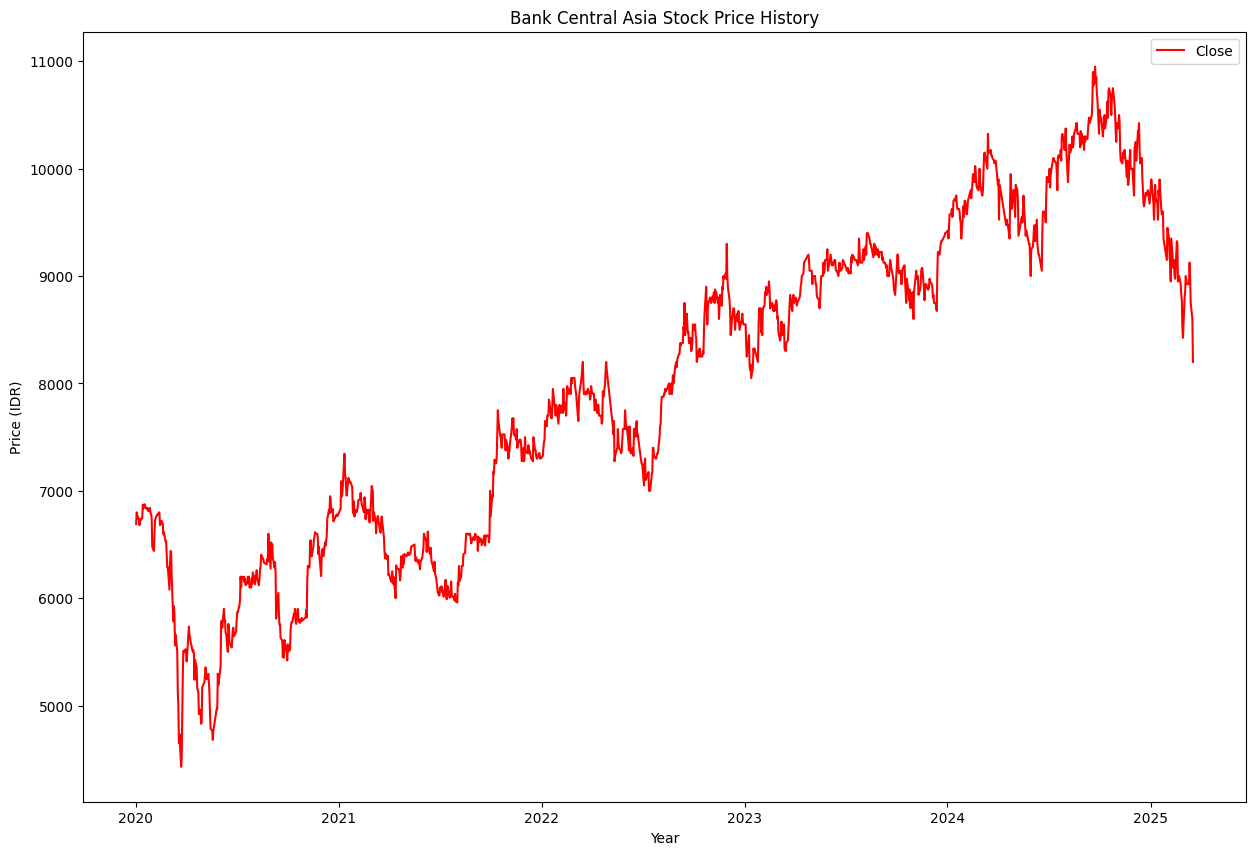

In [161]:
# plot data
plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

x_dates = stock_data['Date']

plt.plot(x_dates, stock_data['Close'], 'r', label='Close')
plt.xlabel('Year')
plt.ylabel('Price (IDR)')
plt.title('Bank Central Asia Stock Price History')
plt.legend()
plt.gcf()
plt.show()

### Data Preprocessing

In [162]:
# Feature engineering
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data['Volatility'] = stock_data['Returns'].rolling(window=10).std()
stock_data['Range'] = stock_data['High'] - stock_data['Low']
stock_data['Close_MA_50_diff'] = stock_data['Close'] - stock_data['MA_50']

stock_data.dropna(inplace=True)

# Select features
features = ['Close', 'MA_50', 'MA_200', 'Returns', 'Volatility', 'Range', 'Close_MA_50_diff', 'Vol.']
data = stock_data[features].values
dates = stock_data['Date'].values

# Select data split range
look_back = 60
split_idx = int(len(data) * 0.8)

train_data = data[:split_idx]
test_data = data[split_idx - look_back:]

# Scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequence
def create_sequences(data, look_back):
    x, last_closes, next_closes = [], [], []
    for i in range(look_back, len(data)):
        x.append(data[i - look_back:i])
        last_closes.append(data[i - 1, 0])  # last Close
        next_closes.append(data[i, 0])      # next Close
    return np.array(x), np.array(last_closes), np.array(next_closes)

x_train, last_closes_train_scaled, next_closes_train_scaled = create_sequences(train_scaled, look_back)
x_test, last_closes_test_scaled, next_closes_test_scaled = create_sequences(test_scaled, look_back)

# Unscale closes for y
pad_train = np.zeros((len(last_closes_train_scaled), len(features)))
pad_train[:, 0] = last_closes_train_scaled
last_closes_train_actual = scaler.inverse_transform(pad_train)[:, 0]

pad_next = np.zeros((len(next_closes_train_scaled), len(features)))
pad_next[:, 0] = next_closes_train_scaled
next_closes_train_actual = scaler.inverse_transform(pad_next)[:, 0]

y_train = next_closes_train_actual - last_closes_train_actual  # ΔClose


### Model Building

## Naive Baseline

In [163]:
# Assume 'test_start' and 'test_end' already defined
test_mask = (stock_data['Date'] >= test_start) & (stock_data['Date'] <= test_end)

# Get actual Close prices for the test period
actual_prices_test = stock_data.loc[test_mask, 'Close'].reset_index(drop=True)

# Naive prediction: today's price = yesterday's price
naive_predictions = pd.Series(
    [actual_prices_test.iloc[0]] + actual_prices_test[:-1].tolist()
)

# Evaluation metrics
naive_mse = mean_squared_error(actual_prices_test, naive_predictions)
naive_rmse = np.sqrt(naive_mse)
naive_mae = mean_absolute_error(actual_prices_test, naive_predictions)
naive_mape = np.mean(np.abs((actual_prices_test - naive_predictions) / actual_prices_test)) * 100
naive_r2 = r2_score(actual_prices_test, naive_predictions)

print("\nNaive Baseline Evaluation Metrics:")
print(f"Naive MSE:   {naive_mse:.4f}")
print(f"Naive RMSE:  {naive_rmse:.4f}")
print(f"Naive MAE:   {naive_mae:.4f}")
print(f"Naive MAPE:  {naive_mape:.2f}%")
print(f"Naive R²:    {naive_r2:.4f}")



Naive Baseline Evaluation Metrics:
Naive MSE:   22376.7606
Naive RMSE:  149.5886
Naive MAE:   116.9014
Naive MAPE:  1.20%
Naive R²:    0.9287


213 213 213


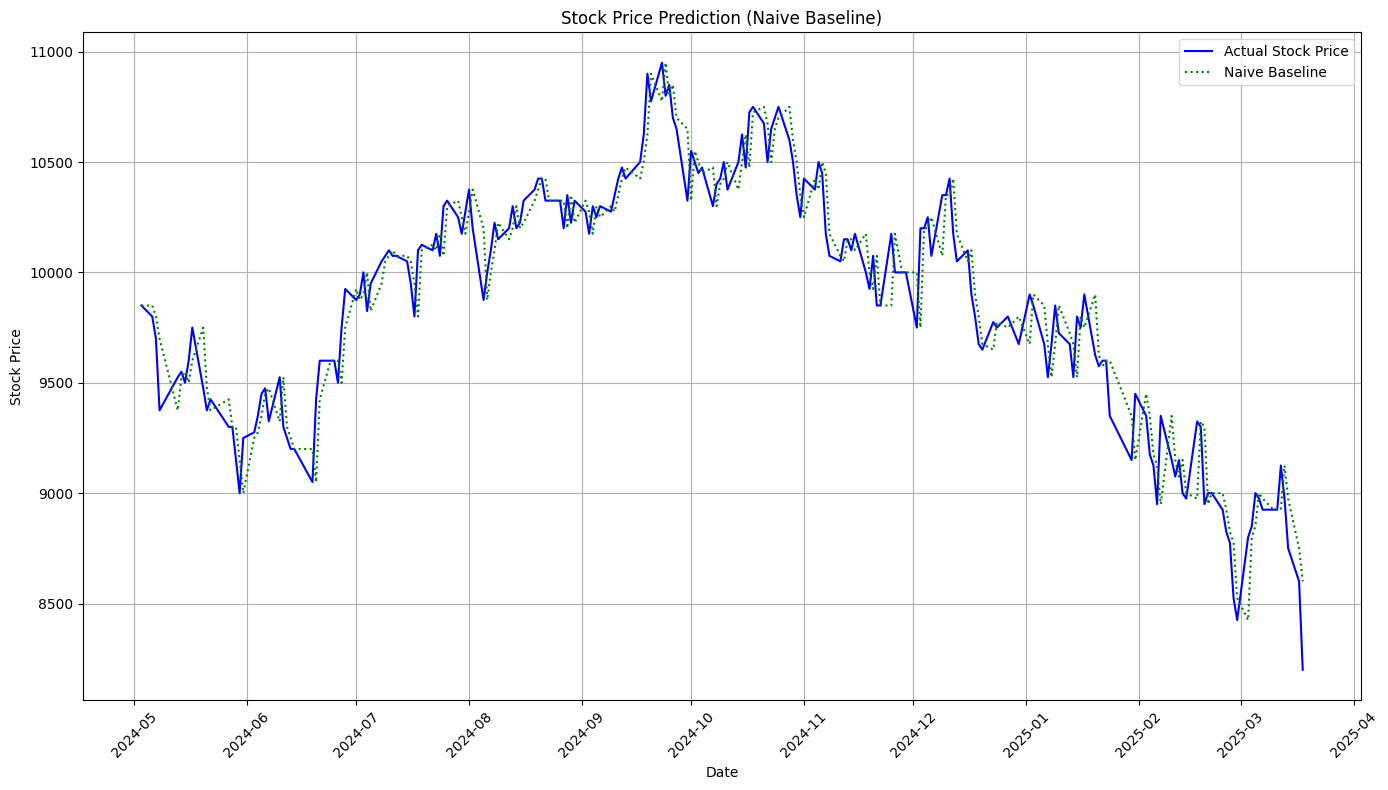

In [164]:
# Calculate start index based on sequence length and scaling
test_data_start_index = len(stock_data) - len(actual_close)

# Slice dates correctly to match actual_close and naive_predictions
test_dates = stock_data['Date'].iloc[test_data_start_index:].reset_index(drop=True)

# Sanity check
print(len(test_dates), len(actual_close), len(naive_predictions))  # Should all match

# Plot
plt.figure(figsize=(14, 8))
plt.plot(test_dates, actual_close, color='blue', label='Actual Stock Price')
plt.plot(test_dates, naive_predictions, color='green', linestyle='dotted', label='Naive Baseline')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (Naive Baseline)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Long Short Term Memory

In [165]:
# LSTM Model
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# === 5. Train Model ===
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# === 6. Predict ===
predicted_delta = model.predict(x_test).ravel()

# Unscale test closes
pad_test = np.zeros((len(last_closes_test_scaled), len(features)))
pad_test[:, 0] = last_closes_test_scaled
last_closes_test_actual = scaler.inverse_transform(pad_test)[:, 0]

pad_next_test = np.zeros((len(next_closes_test_scaled), len(features)))
pad_next_test[:, 0] = next_closes_test_scaled
next_closes_test_actual = scaler.inverse_transform(pad_next_test)[:, 0]

# Reconstruct predicted Close
predicted_close = last_closes_test_actual + predicted_delta
actual_close = next_closes_test_actual

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 10496.6973 - val_loss: 13538.9258
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 10803.5645 - val_loss: 13537.9521
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 10968.3594 - val_loss: 13536.6553
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9685.8926 - val_loss: 13535.4004
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 11471.4668 - val_loss: 13534.7656
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 11871.3672 - val_loss: 13535.8574
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 9938.3281 - val_loss: 13534.7686
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 11616.6133 - val_loss: 13534.6631
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 9999.2354 - val_loss: 13534.7451
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 10710.9082 - val_loss: 13534.4238
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 10703.0010 -

### Evaluation

In [166]:
mse = mean_squared_error(actual_close, predicted_close)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_close, predicted_close)
mape = np.mean(np.abs((actual_close - predicted_close) / actual_close)) * 100
r2 = r2_score(actual_close, predicted_close)

print(f"\nLSTM Evaluation Metrics:")
print(f"LSTM MSE:   {mse:.4f}")
print(f"LSTM RMSE:  {rmse:.4f}")
print(f"LSTM MAE:   {mae:.4f}")
print(f"LSTM MAPE:  {mape:.2f}%")
print(f"LSTM R²:    {r2:.4f}")


LSTM Evaluation Metrics:
LSTM MSE:   22856.1249
LSTM RMSE:  151.1824
LSTM MAE:   118.8978
LSTM MAPE:  1.22%
LSTM R²:    0.9271


213 213 213


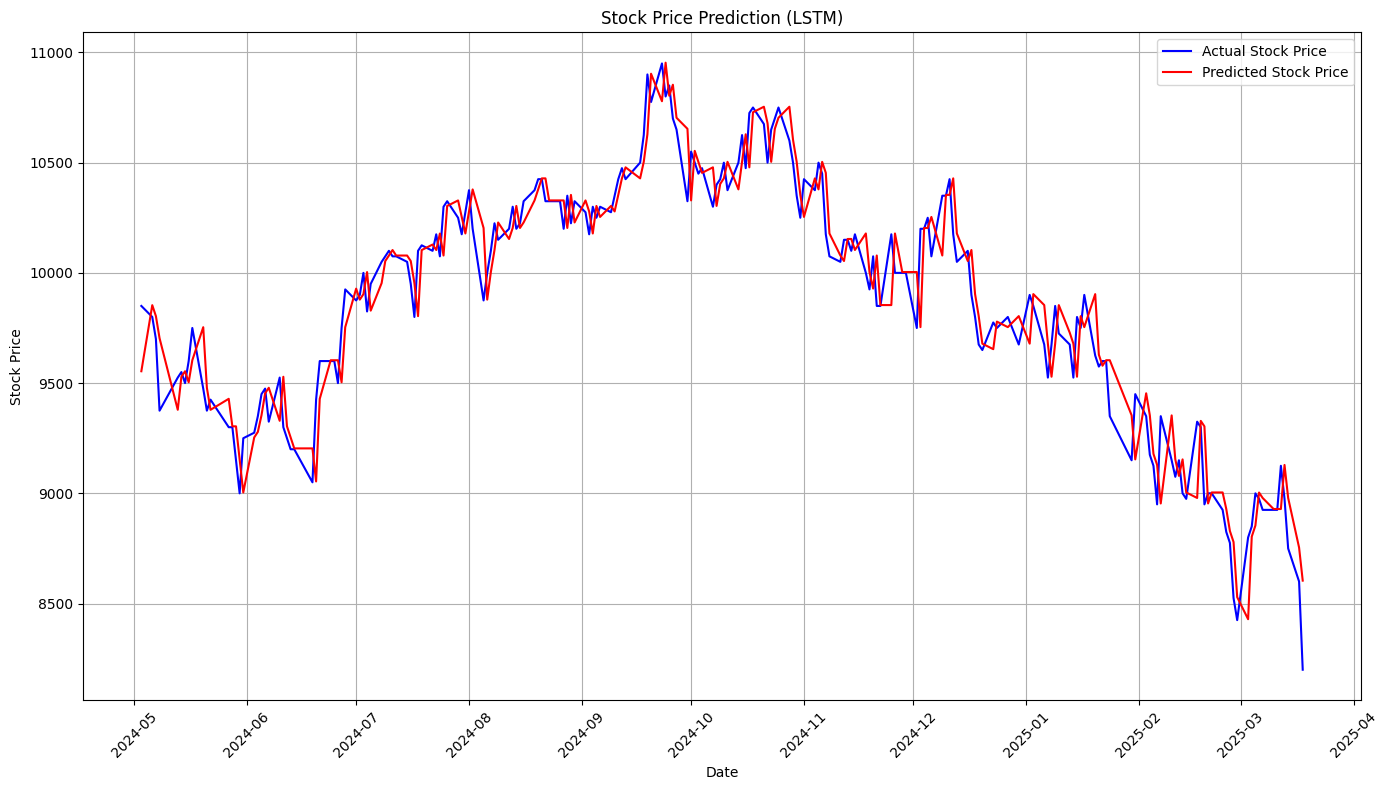

In [167]:
# Calculate start index based on sequence length and scaling
test_data_start_index = len(stock_data) - len(actual_close)

# Slice dates correctly to match actual_close and predicted_close
test_dates = stock_data['Date'].iloc[test_data_start_index:].reset_index(drop=True)

# Ensure lengths match
print(len(test_dates), len(actual_close), len(predicted_close))  # Sanity check

plt.figure(figsize=(14, 8))
plt.plot(test_dates, actual_close, color='blue', label='Actual Stock Price')
plt.plot(test_dates, predicted_close, color='red', label='Predicted Stock Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction (LSTM)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Lengths: 213 213 213 213


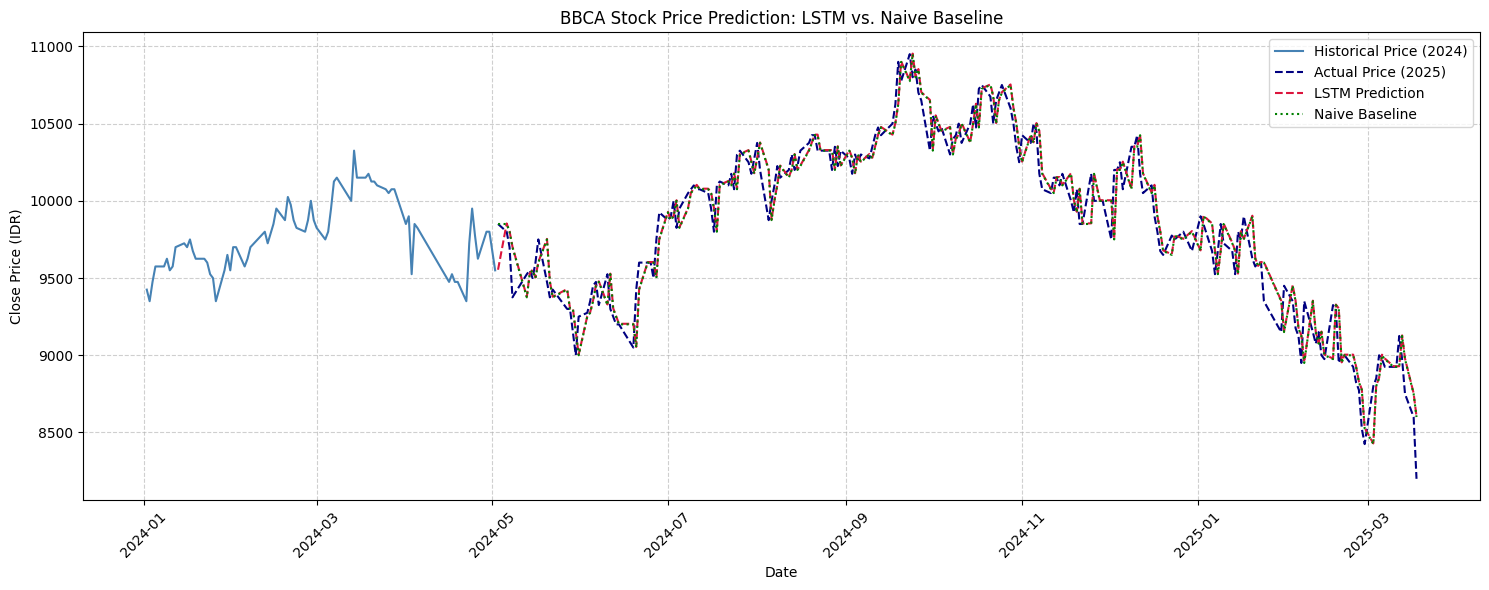

In [168]:
# Determine start index after sequence slicing
test_data_start_index = len(stock_data) - len(actual_close)

# Extract matching dates for the test period
test_dates = stock_data['Date'].iloc[test_data_start_index:].reset_index(drop=True)

# Historical data (optional, for context)
historical_start = '2024-01-01'
test_start = stock_data['Date'].iloc[test_data_start_index]
historical_mask = (stock_data['Date'] >= historical_start) & (stock_data['Date'] < test_start)
dates_historical = stock_data.loc[historical_mask, 'Date'].reset_index(drop=True)
historical_prices = stock_data.loc[historical_mask, 'Close'].reset_index(drop=True)

# Ensure lengths match
print("Lengths:", len(test_dates), len(actual_close), len(predicted_close), len(naive_predictions))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(dates_historical, historical_prices, label='Historical Price (2024)', color='steelblue')
plt.plot(test_dates, actual_close, label='Actual Price (2025)', color='navy', linestyle='dashed')
plt.plot(test_dates, predicted_close, label='LSTM Prediction', color='crimson', linestyle='--')
plt.plot(test_dates, naive_predictions, label='Naive Baseline', color='green', linestyle='dotted')

plt.title('BBCA Stock Price Prediction: LSTM vs. Naive Baseline')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
